<a href="https://colab.research.google.com/github/Hamza80saidi/AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection/blob/main/fine_tuning_arabert_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning AraBERT (aubmindlab/bert-base-arabertv2)

Notebook organisé, simple et prêt pour Google Colab. Prépare le dataset `KFUPM-JRCAI/arabic-generated-social-media-posts`, équilibre humain vs IA, entraîne avec loss pondérée, logue sur W&B, trace des courbes, et propose une petite interface Gradio.

Instructions rapides:
1. Exécute les cellules séquentiellement.
2. Si tu veux utiliser W&B, connecte-toi dans la cellule `# W&B Login`.
3. Ce notebook utilise `aubmindlab/bert-base-arabertv2`.

In [1]:
!pip install -q transformers datasets accelerate arabert PyArabic farasapy evaluate wandb gradio[sockets]
!pip install -q sacrebleu seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration
MODEL_NAME = 'aubmindlab/bert-base-arabertv2'
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 3
LR = 2e-5
MAX_LENGTH = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE=='cuda':
    torch.cuda.manual_seed_all(SEED)

print('Device:', DEVICE)

Device: cuda


In [3]:
# Load dataset from HF and prepare balanced HUMAN vs AI
from datasets import load_dataset

ds = load_dataset('KFUPM-JRCAI/arabic-generated-social-media-posts')
df = ds['train'].to_pandas()
print('Raw dataset shape:', df.shape)
print('Columns:', df.columns.tolist())

df_head = df[['original_post', 'allam_generated_post','jais_generated_post','llama_generated_post','openai_generated_post']].head()
df_head

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/43.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3318 [00:00<?, ? examples/s]

Raw dataset shape: (3318, 5)
Columns: ['original_post', 'allam_generated_post', 'jais_generated_post', 'llama_generated_post', 'openai_generated_post']


,original_post,allam_generated_post,jais_generated_post,llama_generated_post,openai_generated_post
0,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...
1,الطلياني شكري المبخوت. شكري المبخوت هو كاتب تو...,الطلياني شكري المبخوت هو كاتب تونسي ورئيس جامع...,شكري المبخوت هو كاتب تونسي ورئيس جامعة منوبة ا...,الطلياني شكري المبخوت. شكري المبخوت هو كاتب تو...,شكري المبخوت، الكاتب التونسي البارز، ورئيس جام...
2,نهاية فؤاد حداد تتجلى في هذا الديوان، صور تعبي...,نهاية فؤاد حداد تتجلى في هذا الديوان، صور تعبي...,نهاية فؤاد حداد تتجلى في هذا الديوان، صور تعبي...,نهاية فؤاد حداد تتجلى في هذا الديوان، صور تعبي...,نهاية فؤاد حداد تتجلى في هذا الديوان؛ صور تعبي...
3,لماذا يحب التاريخ أن يعيد نفسه في الدول المتخل...,لماذا يحب التاريخ أن يعيد نفسه في الدول المتخل...,لماذا يحب التاريخ أن يعيد نفسه في الدول المتخل...,لماذا يحب التاريخ أن يعيد نفسه في الدول المتخل...,لماذا يُعجب التاريخ بإعادة نفسه في الدول المتخ...
4,"من هو ""يوسف زيدان""؟. أتراه متشكك فى كل العقائد...","من هو ""يوسف زيدان""؟ أتراه متشكك في كل العقائد،...",هل يوسف زيدان متشكك في جميع العقائد، متردد بين...,"من هو ""يوسف زيدان""؟ أتراه متشكك في كل العقائد،...","من هو ""يوسف زيدان""؟ هل هو متشكك في كل العقائد،..."


In [4]:
# Build binary dataset (label 0 = human, 1 = ai) and balance it
human_df = pd.DataFrame({'text': df['original_post'].astype(str), 'label': 0})
ai_texts = pd.concat([
    df['allam_generated_post'].astype(str),
    df['jais_generated_post'].astype(str),
    df['llama_generated_post'].astype(str),
    df['openai_generated_post'].astype(str)
], ignore_index=True)
ai_df = pd.DataFrame({'text': ai_texts, 'label': 1})

min_len = min(len(human_df), len(ai_df))
human_df = human_df.sample(n=min_len, random_state=SEED)
ai_df = ai_df.sample(n=min_len, random_state=SEED)

df_binary = pd.concat([human_df, ai_df], axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)
print('Balanced dataset size:', df_binary.shape)
print(df_binary['label'].value_counts())

df_binary.head()

Balanced dataset size: (6636, 2)
label
0    3318
1    3318
Name: count, dtype: int64


,text,label
0,مدخل:. قال الرافعي في مدخل كتابه السحاب الأحمر...,0
1,لا يعنيه هنا سرد بكائية على دينٍ مهزومٍ منذ زم...,1
2,كتاب رائع. بعض الكلمات التي جذبت انتباهي في هذ...,1
3,رأيت كأني أشتري شيئًا، ثم مسَّت يداي يديها، فش...,0
4,مُنذ فترة لم أُعطِ كتاباً أو عملاً أدبياً تقيي...,1


In [5]:
# Train / Val / Test split
train_df, test_df = train_test_split(df_binary, test_size=0.15, random_state=SEED, stratify=df_binary['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1765, random_state=SEED, stratify=train_df['label'])
# -> around 70% train, 15% val, 15% test
print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in ['text','label']])
val_ds = val_ds.remove_columns([c for c in val_ds.column_names if c not in ['text','label']])
test_ds = test_ds.remove_columns([c for c in test_ds.column_names if c not in ['text','label']])

train_ds[0]

Train: 4644 Val: 996 Test: 996


{'text': 'تلخيص: يعتمد الكاتب في مستهل الكتاب على عملية استقراء للنص القرآني من أجل إحصاء عشرات الآيات التي تعلل امتناع الله عن إتيان المعجزات التي يطالبه بها رسوله أو المؤمنون به، و特别 اللامؤمنون. و بنى على أساس هذه الآيات خمسة تعليلات استنتجها منها و من غيرها في الفصل الأول "نبي بلا معجزة". و لم يقفل الباب نهائيا من حيث عدم إيراده للفظ قاطع بخصوص النبي و المعجزات، لكون بعضها مثبتا في القرآن - حتى و إن لم يتطرق لها و لو بالتعريض. أما الفصل الثاني "نبي الثلاثة آلاف معجزة" و ما تلاه من فصول فهو أشبه ما يكون بتجميع ناتج عن نبش في الكتب التراثية بحثا عن أكبر عدد من الأحاديث و المرويات و الآثار الدالة على أفعال الرسول التي فيها خرق لقوانين الطبيعة، أو تلك الأفعال التي تشمل على قدر أكبر من تضخم الخيال بحيث تشمل الأفعال الخارقة لقوانين الطبية و الفيزياء و المنطق و المألوف قام بها الأئمة الاثنا عشر عند الشيعة بشكل "يستحضر للذهن غرائبيات الف ليلة و ليلة و خوارق الإلياذة و الأوديسة". الفصل الخامس - 16 صفحة - يمكن اعتباره محاولة لتفسير أسباب استحداث المعجزة في الإسلام بشقيه السني و الشيعي حيث كان

In [6]:
# Tokenizer and preprocessing
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, padding=False, max_length=MAX_LENGTH)

train_tok = train_ds.map(preprocess, batched=True)
val_tok = val_ds.map(preprocess, batched=True)
test_tok = test_ds.map(preprocess, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(train_tok[0])

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4644 [00:00<?, ? examples/s]

Map:   0%|          | 0/996 [00:00<?, ? examples/s]

Map:   0%|          | 0/996 [00:00<?, ? examples/s]

{'text': 'تلخيص: يعتمد الكاتب في مستهل الكتاب على عملية استقراء للنص القرآني من أجل إحصاء عشرات الآيات التي تعلل امتناع الله عن إتيان المعجزات التي يطالبه بها رسوله أو المؤمنون به، و特别 اللامؤمنون. و بنى على أساس هذه الآيات خمسة تعليلات استنتجها منها و من غيرها في الفصل الأول "نبي بلا معجزة". و لم يقفل الباب نهائيا من حيث عدم إيراده للفظ قاطع بخصوص النبي و المعجزات، لكون بعضها مثبتا في القرآن - حتى و إن لم يتطرق لها و لو بالتعريض. أما الفصل الثاني "نبي الثلاثة آلاف معجزة" و ما تلاه من فصول فهو أشبه ما يكون بتجميع ناتج عن نبش في الكتب التراثية بحثا عن أكبر عدد من الأحاديث و المرويات و الآثار الدالة على أفعال الرسول التي فيها خرق لقوانين الطبيعة، أو تلك الأفعال التي تشمل على قدر أكبر من تضخم الخيال بحيث تشمل الأفعال الخارقة لقوانين الطبية و الفيزياء و المنطق و المألوف قام بها الأئمة الاثنا عشر عند الشيعة بشكل "يستحضر للذهن غرائبيات الف ليلة و ليلة و خوارق الإلياذة و الأوديسة". الفصل الخامس - 16 صفحة - يمكن اعتباره محاولة لتفسير أسباب استحداث المعجزة في الإسلام بشقيه السني و الشيعي حيث كان

In [7]:
# Compute class weights (to handle imbalance) and prepare them for loss
import numpy as np
labels = np.array(train_df['label'].tolist())
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print('Class weights:', class_weights)

Class weights: tensor([1., 1.])


In [8]:
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, Trainer

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

# Subclass Trainer to inject weighted loss
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get('labels')
        outputs = model(**{k: v for k, v in inputs.items() if k != 'labels'})
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

print('Model and WeightedTrainer ready')

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and WeightedTrainer ready


In [9]:
import evaluate

accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')
precision = evaluate.load('precision')
recall = evaluate.load('recall')


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy.compute(predictions=preds, references=p.label_ids)['accuracy'],
        'f1': f1.compute(predictions=preds, references=p.label_ids, average='macro')['f1'],
        'precision': precision.compute(predictions=preds, references=p.label_ids, average='macro')['precision'],
        'recall': recall.compute(predictions=preds, references=p.label_ids, average='macro')['recall']
    }

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LR,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

print('Training args set')

Training args set


In [10]:
!wandb login 66d4e657f25f0601b3527ca4ebc73017a4aa1e0d


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [11]:
# Optional: W&B login (run this cell and follow instructions to link W&B)
# If you don't want to use W&B, skip running the two lines below
import wandb
print('Run: wandb login')
wandb.login()  # uncomment if you want to programmatically login

wandb.init(
    project="fine_tuning",
    name="arabert",
    settings=wandb.Settings(init_timeout=300)   # 5 minutes
)

print('If using W&B, set project via TrainingArguments or WANDB_PROJECT env var')

Run: wandb login


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: saidihamza (saidihamza-fp-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


If using W&B, set project via TrainingArguments or WANDB_PROJECT env var


In [12]:
# Instantiate trainer and train
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights


)

train_result = trainer.train()
trainer.save_model('./saved_model')

metrics = train_result.metrics
print('Training finished — metrics:', metrics)

# Evaluate on test set
eval_res = trainer.evaluate(eval_dataset=test_tok)
print('Test results:', eval_res)

/tmp/ipython-input-2020465227.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 31}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.303400,0.352990,0.861446,0.861426,0.861656,0.861446
2,0.223600,0.298583,0.886546,0.885899,0.895517,0.886546
3,0.204800,0.347627,0.874498,0.874431,0.875299,0.874498


Training finished — metrics: {'train_runtime': 244.0658, 'train_samples_per_second': 57.083, 'train_steps_per_second': 3.577, 'total_flos': 1832831611637760.0, 'train_loss': 0.26953799399586753, 'epoch': 3.0}


Test results: {'eval_loss': 0.3029787838459015, 'eval_accuracy': 0.8815261044176707, 'eval_f1': 0.8810349016114665, 'eval_precision': 0.8879331551240632, 'eval_recall': 0.8815261044176707, 'eval_runtime': 7.0133, 'eval_samples_per_second': 142.015, 'eval_steps_per_second': 8.983, 'epoch': 3.0}


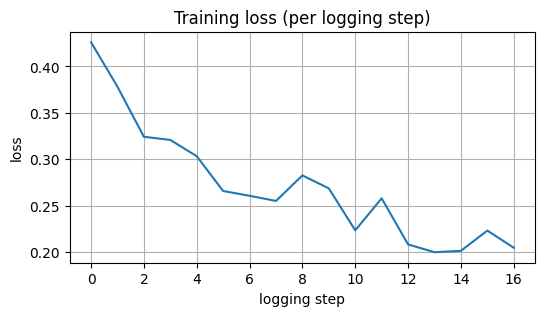

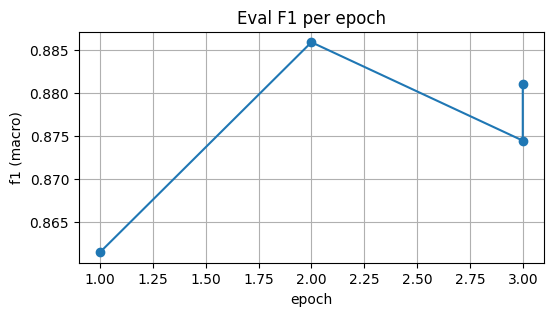

In [13]:
# Simple plots (loss & eval f1 if available)
import matplotlib.pyplot as plt
hist = trainer.state.log_history

# extract epoch-wise metrics
epochs = []
train_losses = []
eval_f1s = []
for entry in hist:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
    if 'epoch' in entry and 'eval_f1' in entry:
        epochs.append(entry['epoch'])
        eval_f1s.append(entry['eval_f1'])

if train_losses:
    plt.figure(figsize=(6,3))
    plt.plot(train_losses)
    plt.title('Training loss (per logging step)')
    plt.xlabel('logging step')
    plt.ylabel('loss')
    plt.grid(True)
    plt.show()

if epochs and eval_f1s:
    plt.figure(figsize=(6,3))
    plt.plot(epochs, eval_f1s, marker='o')
    plt.title('Eval F1 per epoch')
    plt.xlabel('epoch')
    plt.ylabel('f1 (macro)')
    plt.grid(True)
    plt.show()

In [14]:
# Simple inference + Gradio demo
import gradio as gr

def predict(text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred = int(probs.argmax())
    label_map = {0: 'human', 1: 'ai'}
    return { 'label': label_map[pred], 'human_prob': float(probs[0]), 'ai_prob': float(probs[1]) }

iface = gr.Interface(fn=predict, inputs=gr.Textbox(lines=5, placeholder='Écris un texte...'),
                     outputs=[gr.Label(num_top_classes=2), gr.Number(label='human_prob'), gr.Number(label='ai_prob')],
                     title='Human vs AI (AraBERT fine-tuned)')

# Display the Gradio interface link when running in Colab
print('To launch the Gradio app, run: iface.launch(share=True)')

To launch the Gradio app, run: iface.launch(share=True)


In [17]:
# Quick local tests (change the text below)
examples = [
    'هذا تدوين بشري نموذجي يتحدث عن الثقافة العربية والموسيقى',
    'في هذا المقال سنتحدث عن التطورات الأخيرة في ...'
]
for t in examples:
    print(t)
    print(predict(t))
    print('---')

هذا تدوين بشري نموذجي يتحدث عن الثقافة العربية والموسيقى
{'label': 'human', 'human_prob': 0.8078399300575256, 'ai_prob': 0.19216008484363556}
---
في هذا المقال سنتحدث عن التطورات الأخيرة في ...
{'label': 'human', 'human_prob': 0.799755334854126, 'ai_prob': 0.2002447247505188}
---


In [19]:
import gradio as gr

def predict(text):
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred = int(probs.argmax())
        label_map = {0: "human", 1: "ai"}
        return label_map[pred], float(probs[0]), float(probs[1])

iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=5, placeholder="Écris un texte..."),
    outputs=[
        gr.Label(num_top_classes=2),
        gr.Number(label="human_prob"),
        gr.Number(label="ai_prob")
    ],
    title="Human vs AI (AraBERT fine-tuned)"
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://04528af93ea329bc5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
